In [1]:
import pandas as pd
from datetime import datetime
from darts import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [148]:
data_path = 'db.csv'

In [149]:
df = pd.read_csv(f'{data_path}', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64765 entries, 0 to 64764
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Billing date       64765 non-null  int64 
 1   Material           64765 non-null  int64 
 2   Phisical quantity  64765 non-null  int64 
 3   Country            64765 non-null  int64 
 4   Net price          64765 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.5+ MB


In [150]:
df.head(10)

,Billing date,Material,Phisical quantity,Country,Net price
0,10052022,1795,10,7511,"2,865"
1,10052022,1778,5,7511,"0,66375"
2,10052022,1778,15,7511,"0,66375"
3,10052022,9526,4,7511,"36,31125"
4,10052022,1778,11,7511,"0,66375"
5,10052022,1778,15,7511,"0,66375"
6,10052022,1778,5,7511,"0,66375"
7,10052022,2844,2,7511,"35,185"
8,10052022,4151,6,7511,"31,47875"
9,10052022,2844,2,7511,"35,185"


## Análisis exploratorio

### Creamos una columna de fecha

In [151]:
def process_date_str(number):
    string = str(number)
    if len(string) == 7:
        string = '0' + string
    return f'{string[4:]}-{string[2:4]}-{string[:2]}'

In [152]:
df['time_str'] = df['Billing date'].apply(process_date_str)
df['time'] = pd.to_datetime(df['time_str'], format='%Y-%m-%d')
df

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
0,10052022,1795,10,7511,"2,865",2022-05-10,2022-05-10
1,10052022,1778,5,7511,"0,66375",2022-05-10,2022-05-10
2,10052022,1778,15,7511,"0,66375",2022-05-10,2022-05-10
3,10052022,9526,4,7511,"36,31125",2022-05-10,2022-05-10
4,10052022,1778,11,7511,"0,66375",2022-05-10,2022-05-10
...,...,...,...,...,...,...,...
64760,30042024,1634,100,1526,"2,5175",2024-04-30,2024-04-30
64761,30042024,1634,2,1526,"2,5175",2024-04-30,2024-04-30
64762,30042024,1634,60,1526,"2,5175",2024-04-30,2024-04-30
64763,30042024,1679,2,1526,"29,5575",2024-04-30,2024-04-30


## Agrupacion de ventas diarias

In [153]:
first_sale = df['time'].min()
first_sale

Timestamp('2018-08-24 00:00:00')

In [154]:
last_sale = df['time'].max()
last_sale

Timestamp('2024-09-26 00:00:00')

### Agrupación de ventas por ítem

Vemos la cantidad de ventas por ítem

In [155]:
df['Net price'] = df['Net price'].apply(lambda x: x.replace(',', '.')).astype(float)

In [156]:
df.head()

,Billing date,Material,Phisical quantity,Country,Net price,time_str,time
0,10052022,1795,10,7511,2.86500,2022-05-10,2022-05-10
1,10052022,1778,5,7511,0.66375,2022-05-10,2022-05-10
2,10052022,1778,15,7511,0.66375,2022-05-10,2022-05-10
3,10052022,9526,4,7511,36.31125,2022-05-10,2022-05-10
4,10052022,1778,11,7511,0.66375,2022-05-10,2022-05-10


In [157]:
grouped_daily_df_1 = df.groupby(['time',]).sum().reset_index()[['time', 'Phisical quantity']]
grouped_daily_df_median = df[['time', 'Net price']].groupby(['time',]).median().reset_index()[['time', 'Net price']]
grouped_daily_df_mean = df[['time', 'Net price']].groupby(['time',]).mean().reset_index()[['time', 'Net price']]
grouped_daily_df = grouped_daily_df_1.join(
    grouped_daily_df_median, how='inner', rsuffix='_right_median').join(
       grouped_daily_df_mean, how='inner', rsuffix='_right_mean' 
    ).rename(columns={
        'Net price': 'median_price', 
        'Net price_right_mean': 'mean_price',
        'Phisical quantity': 'sales',
    })[['time', 'sales', 'median_price', 'mean_price']]
grouped_daily_df

,time,sales,median_price,mean_price
0,2018-08-24,620,4.360000,6.683052
1,2018-08-27,2640,2.483750,3.770110
2,2018-08-28,2874,1.970000,2.970656
3,2018-08-30,11,0.710000,0.710000
4,2018-08-31,4473,4.571250,6.694622
...,...,...,...,...
640,2024-09-18,9033,13.153125,13.794169
641,2024-09-19,6325,3.071250,6.253629
642,2024-09-20,1367,10.851875,11.898160
643,2024-09-25,1564,9.013125,12.805475


#### Agrupación mensual

In [158]:
grouped_daily_df['time_trunc'] = grouped_daily_df['time'].to_numpy().astype('datetime64[M]')
grouped_daily_df['time_trunc'] = pd.to_datetime(grouped_daily_df['time_trunc'], format='%Y-%m-%d')
grouped_daily_df

,time,sales,median_price,mean_price,time_trunc
0,2018-08-24,620,4.360000,6.683052,2018-08-01
1,2018-08-27,2640,2.483750,3.770110,2018-08-01
2,2018-08-28,2874,1.970000,2.970656,2018-08-01
3,2018-08-30,11,0.710000,0.710000,2018-08-01
4,2018-08-31,4473,4.571250,6.694622,2018-08-01
...,...,...,...,...,...
640,2024-09-18,9033,13.153125,13.794169,2024-09-01
641,2024-09-19,6325,3.071250,6.253629,2024-09-01
642,2024-09-20,1367,10.851875,11.898160,2024-09-01
643,2024-09-25,1564,9.013125,12.805475,2024-09-01


In [159]:
# Filtramos por el ítem y calculamos la distribución mensual de ventas
grouped_monthly_df_1 = grouped_daily_df[['time_trunc', 'sales',]].groupby('time_trunc').sum().reset_index()[['time_trunc', 'sales']]
grouped_monthly_df_median = grouped_daily_df[['time_trunc', 'median_price',]].groupby('time_trunc').median().reset_index()[['time_trunc', 'median_price']]
grouped_monthly_df_mean = grouped_daily_df[['time_trunc', 'mean_price',]].groupby('time_trunc').median().reset_index()[['time_trunc', 'mean_price']]

grouped_monthly_df = grouped_monthly_df_1.join(
    grouped_monthly_df_median, how='inner', rsuffix='_right_median').join(
       grouped_monthly_df_mean, how='inner', rsuffix='_right_mean' 
    ).rename(columns={
        'time_trunc': 'time',
    })[['time', 'sales', 'median_price', 'mean_price']]
grouped_monthly_df

,time,sales,median_price,mean_price
0,2018-08-01,10618,2.483750,3.770110
1,2018-09-01,25151,5.523125,7.350582
2,2018-10-01,32525,4.937500,7.213026
3,2018-11-01,24869,3.611875,5.419263
4,2018-12-01,11721,4.514375,7.643324
...,...,...,...,...
69,2024-05-01,49145,6.551875,9.686250
70,2024-06-01,43994,5.794062,8.871295
71,2024-07-01,31641,4.104375,9.036203
72,2024-08-01,33907,5.712500,8.613187


In [160]:
grouped_daily_df = grouped_daily_df[['time', 'sales','median_price', 'mean_price']]
grouped_daily_df

,time,sales,median_price,mean_price
0,2018-08-24,620,4.360000,6.683052
1,2018-08-27,2640,2.483750,3.770110
2,2018-08-28,2874,1.970000,2.970656
3,2018-08-30,11,0.710000,0.710000
4,2018-08-31,4473,4.571250,6.694622
...,...,...,...,...
640,2024-09-18,9033,13.153125,13.794169
641,2024-09-19,6325,3.071250,6.253629
642,2024-09-20,1367,10.851875,11.898160
643,2024-09-25,1564,9.013125,12.805475


### Plot de ventas

Ajustamos los datos para observar con más claridad

In [161]:
grouped_daily_df['sales_thousands'] = grouped_daily_df['sales'] / 1_000
grouped_monthly_df['sales_thousands'] = grouped_monthly_df['sales'] / 10_000
grouped_daily_df

,time,sales,median_price,mean_price,sales_thousands
0,2018-08-24,620,4.360000,6.683052,0.620
1,2018-08-27,2640,2.483750,3.770110,2.640
2,2018-08-28,2874,1.970000,2.970656,2.874
3,2018-08-30,11,0.710000,0.710000,0.011
4,2018-08-31,4473,4.571250,6.694622,4.473
...,...,...,...,...,...
640,2024-09-18,9033,13.153125,13.794169,9.033
641,2024-09-19,6325,3.071250,6.253629,6.325
642,2024-09-20,1367,10.851875,11.898160,1.367
643,2024-09-25,1564,9.013125,12.805475,1.564


In [162]:
grouped_monthly_df

,time,sales,median_price,mean_price,sales_thousands
0,2018-08-01,10618,2.483750,3.770110,1.0618
1,2018-09-01,25151,5.523125,7.350582,2.5151
2,2018-10-01,32525,4.937500,7.213026,3.2525
3,2018-11-01,24869,3.611875,5.419263,2.4869
4,2018-12-01,11721,4.514375,7.643324,1.1721
...,...,...,...,...,...
69,2024-05-01,49145,6.551875,9.686250,4.9145
70,2024-06-01,43994,5.794062,8.871295,4.3994
71,2024-07-01,31641,4.104375,9.036203,3.1641
72,2024-08-01,33907,5.712500,8.613187,3.3907


Ploteamos

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Ventas diarias (en miles) vs precio')

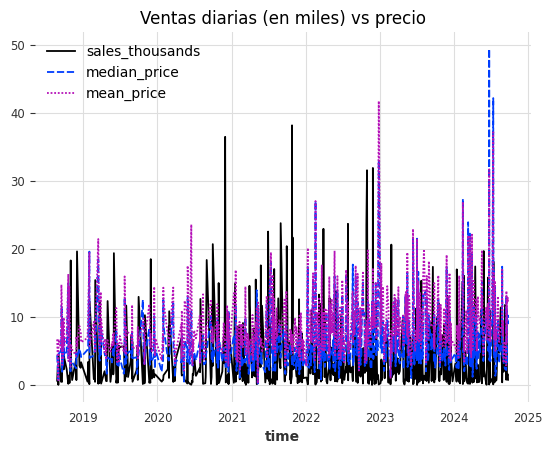

In [164]:
ax1 = sns.lineplot(data=grouped_daily_df.set_index('time')[['sales_thousands','median_price', 'mean_price']])

plt.title('Ventas diarias (en miles) vs precio')

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Ventas mensuales (en diez miles) vs precio')

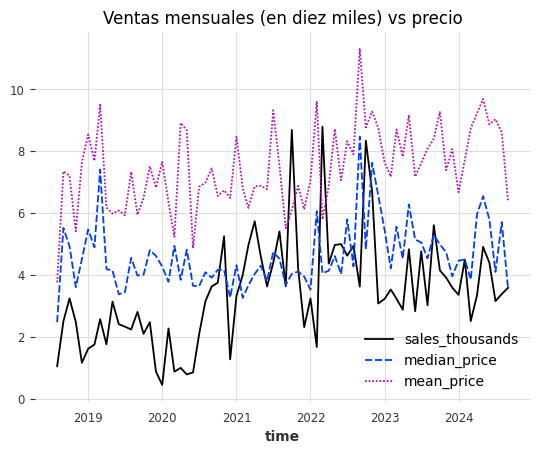

In [165]:
ax2 = sns.lineplot(data=grouped_monthly_df.set_index('time')[['sales_thousands','median_price', 'mean_price']])

plt.title('Ventas mensuales (en diez miles) vs precio')